In [1]:
# MODULE IMPORTS
import os
import sys
sys.path.append("..")
from deconfounder.causal_tree import CausalTree
from deconfounder.deconfounder_tree_tmp import DeconfounderTree
# OTHER IMPORTS
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
import pandas as pd
from sklearn.model_selection import train_test_split

Generate data

In [2]:
np.random.seed(42)
data_size = 5000
feature_size = 10
coefs = npr.uniform(size=feature_size) - 0.5
causal_coefs = np.zeros(feature_size)
# Only the first coefficient is causal
coefs[0] = 0.2
causal_coefs[0] = 1
X = npr.binomial(1, 0.5, size=(data_size, feature_size))
T = npr.binomial(1, 0.5, size=data_size)
Yu = np.dot(X, coefs * (causal_coefs == 0))
Yt = np.dot(X, coefs) - 0.1
Effect = Yt - Yu
Y = T*Yt + (1-T)*Yu
X = pd.DataFrame(X)
X['treated'] = T

Try causal tree.

Best parameters set found on development set:
{'min_samples_leaf': 1400}
Max Causal Impact: 0.05
Model Causal Impact: 0.05
Average Causal Impact: -0.01


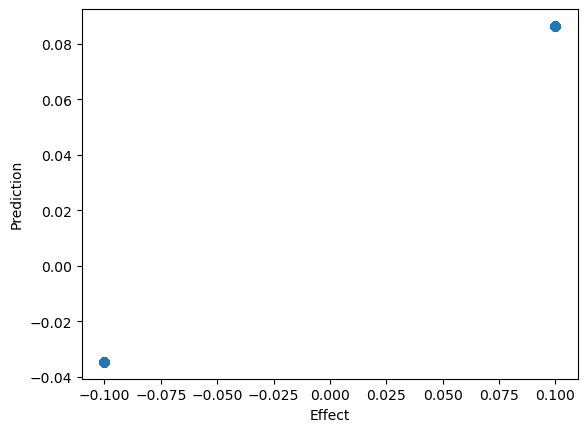

In [3]:
# Split data
X_train, X_test, \
y_train, y_test, \
effect_train, effect_test, \
t_train, t_test = train_test_split(X, Y, Effect, T, random_state=42, test_size=0.20)
# Build causal tree
tuned_parameters = [{'min_samples_leaf': range(200, 2500, 50)}]
clf = GridSearchCV(CausalTree(), tuned_parameters, cv=10)
clf.fit(X_train, y_train)
print("Best parameters set found on development set:")
print(clf.best_params_)
pred = clf.predict(X_test)
# Make the causal tree identifies the only causal feature
plt.scatter(effect_test, pred)
plt.xlabel("Effect")
plt.ylabel("Prediction")

def causal_impact(decisions):
    return effect_test[decisions].mean() * decisions.mean()

print (f"Max Causal Impact: {causal_impact(effect_test>0):.2f}")
print (f"Model Causal Impact: {causal_impact(pred>0):.2f}")
print (f"Average Causal Impact: {causal_impact(np.full(effect_test.size, True)):.2f}")

Try deconfounder tree with random scores.

In [4]:
X_train_f = X_train[X_train.columns[X_train.columns != "treated"]]
X_test_f  = X_test[X_test.columns[X_test.columns != "treated"]]

# Create random scores
np.random.seed(42)
scores_train = npr.uniform(size=effect_train.size) - 0.5
scores_test = npr.uniform(size=effect_test.size) - 0.5

# Build deconfounder tree
tuned_parameters = [{'min_samples_leaf': range(200, 2501, 50)}]
dt = GridSearchCV(DeconfounderTree(), tuned_parameters, cv=10)
comb = pd.DataFrame(np.array([t_train, 
                              y_train, 
                              scores_train, 
                              np.zeros(scores_train.size)]).T, 
                    columns=["t", "y", "scores", "cost"])
dt.fit(X_train_f, comb)
print("Best parameters set found on development set:")
print(dt.best_params_)
corrected_scores = scores_test - dt.predict(X_test_f.values)

print (f"Uncorrected Causal Impact: {causal_impact(scores_test>0):.2f}")
print (f"Corrected Causal Impact: {causal_impact(corrected_scores > 0):.2f}")

Best parameters set found on development set:
{'min_samples_leaf': 950}
Uncorrected Causal Impact: -0.01
Corrected Causal Impact: 0.02


In [5]:
from sklearn.tree import export_text

tree_rules = export_text(dt.best_estimator_, feature_names = list(X_train_f.columns))
print(tree_rules)

|--- 0 <= 0.50
|   |--- 2 <= 0.50
|   |   |--- value: [0.46]
|   |--- 2 >  0.50
|   |   |--- value: [-0.45]
|--- 0 >  0.50
|   |--- 5 <= 0.50
|   |   |--- value: [-0.50]
|   |--- 5 >  0.50
|   |   |--- value: [-0.39]



Let's figure out why is this thing picking such a weird threshold when 0 <= 0.50 and 2 > 0.50.